# PV ENERGY PROJECTION FILE

## imports

### standard modules

In [57]:
from datetime import timedelta
import pickle


### data science / machine learning modules

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, LinearRegression
from sklearn import metrics
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

### own modules

In [60]:
from Energy.subTools.weather_data import avg_weather_df
from Energy.subTools.projection_tools import PROJECTION_COLUMNS, MODEL_NAME
from Energy.subTools.projection_tools import projection_in_graph, savings_df_report 
from Energy.my_energy_reports import create_energy_reports
from Energy import set_debug, STORAGE_DIR


## define constant

In [61]:
MODEL_COLUMN = ['%sun', '%midsun', '%cloud', 'avg_temp', 'suntime_minutes']
PROSPECT_MONTHS = 8
RANDOM_STATE = 101

In [62]:
# switch off debugging Energy module
set_debug(False)

False

## model preparation / selection

### data import, cleaning and preparation

In [63]:
# weather historical data import 
weather_df = avg_weather_df()
weather_df

,month,sun,midsun,cloud,day_sum,%sun,%midsun,%cloud,avg_temp,sunrice,sunset,sunrice_minutes,sunset_minutes,suntime_minutes,suntime
0,1,3.6,10.4,17.0,31.0,0.116129,0.335484,0.548387,2,1900-01-01 07:29:00,1900-01-01 16:08:00,449.838710,968.290323,518.451613,1900-01-01 08:38:00
1,2,3.2,10.0,15.0,28.2,0.113475,0.354610,0.531915,3,1900-01-01 06:49:00,1900-01-01 16:57:00,409.448276,1017.517241,608.068966,1900-01-01 10:08:00
2,3,4.4,13.5,13.1,31.0,0.141935,0.435484,0.422581,8,1900-01-01 06:00:00,1900-01-01 17:55:00,360.548387,1075.354839,714.806452,1900-01-01 11:54:00
3,4,5.7,14.9,9.4,30.0,0.190000,0.496667,0.313333,15,1900-01-01 05:45:00,1900-01-01 19:33:00,345.833333,1173.900000,828.066667,1900-01-01 13:48:00
4,5,6.6,16.3,8.1,31.0,0.212903,0.525806,0.261290,20,1900-01-01 04:53:00,1900-01-01 20:19:00,293.258065,1219.709677,926.451613,1900-01-01 15:26:00
5,6,4.8,18.0,7.2,30.0,0.160000,0.600000,0.240000,23,1900-01-01 04:31:00,1900-01-01 20:49:00,271.400000,1249.466667,978.066667,1900-01-01 16:18:00
6,7,7.7,17.0,6.3,31.0,0.248387,0.548387,0.203226,25,1900-01-01 04:49:00,1900-01-01 20:41:00,289.225806,1241.677419,952.451613,1900-01-01 15:52:00
7,8,8.5,16.3,6.2,31.0,0.274194,0.525806,0.200000,26,1900-01-01 05:30:00,1900-01-01 19:56:00,330.903226,1196.516129,865.612903,1900-01-01 14:25:00
8,9,7.5,13.5,9.0,30.0,0.250000,0.450000,0.300000,21,1900-01-01 06:16:00,1900-01-01 18:53:00,376.500000,1133.200000,756.700000,1900-01-01 12:36:00
9,10,9.2,12.4,9.4,31.0,0.296774,0.400000,0.303226,16,1900-01-01 06:59:00,1900-01-01 17:44:00,419.645161,1064.032258,644.387097,1900-01-01 10:44:00


In [64]:
# energy object 
energy_df, _ = create_energy_reports(
    refresh=False, 
    export_back=0.8,
    kWh_cost=0.65,
)

master_monthly_energy_df = energy_df.get_energy.groupby('month').sum().reset_index()
months = master_monthly_energy_df.month.values.tolist()

In [65]:
# cleaning not full months data
for month_id in [0, -1]:
    limits = energy_df.get_energy.loc[energy_df.get_energy.month==months[month_id], 'day'].agg(['min', 'max']).values.tolist()
    if limits[0].day==1 and (limits[1]+ timedelta(days=1)).day==1:
        continue
    months.remove(months[month_id])
    
# removing from energy dataframe
master_monthly_energy_df = master_monthly_energy_df[master_monthly_energy_df.month.isin(months)]
# adding month_str column and chamge month column to month number (to easy join with weather dataframe)
master_monthly_energy_df['month_str'] = master_monthly_energy_df.month
master_monthly_energy_df['month'] = master_monthly_energy_df['month'].str[-2:].astype(int)
master_monthly_energy_df

,month,production_,export_,import_,time,hour,balance_,self_consumption_,total_consumption_,month_str
1,9,680.038,478.873,379.584,59616000,16560,3.5144,201.165,580.749,2021/09
2,10,608.671,390.918,465.153,61603200,17112,-152.4186,217.753,682.906,2021/10
3,11,222.230,119.407,500.029,59616000,16560,-404.5034,102.823,602.852,2021/11
4,12,80.857,27.887,634.565,61603200,17112,-612.2554,52.970,687.535,2021/12


In [66]:
# projection months list
last_month_start = energy_df.get_energy[energy_df.get_energy.month==months[-1]]['day'].min()
projection_months = [(last_month_start + pd.DateOffset(months=1 + x)).strftime("%Y/%m") for x in range(PROSPECT_MONTHS)]

# projection dataframe preparation
projection_df = pd.DataFrame({
    'month': [int(x[-2:]) for x in projection_months],
    'month_str': projection_months
})

In [67]:
# merge weather data with projection dataframe
projection_df = projection_df.merge(weather_df[['month', '%sun', '%midsun', '%cloud', 'avg_temp', 'suntime_minutes']], how='inner', on="month")
# merge weather data with energy dataframe
monthly_energy_df = master_monthly_energy_df.merge(weather_df[['month', '%sun', '%midsun', '%cloud', 'avg_temp', 'suntime_minutes']], how='inner', on="month")

In [68]:
monthly_energy_df

,month,production_,export_,import_,time,hour,balance_,self_consumption_,total_consumption_,month_str,%sun,%midsun,%cloud,avg_temp,suntime_minutes
0,9,680.038,478.873,379.584,59616000,16560,3.5144,201.165,580.749,2021/09,0.250000,0.450000,0.300000,21,756.700000
1,10,608.671,390.918,465.153,61603200,17112,-152.4186,217.753,682.906,2021/10,0.296774,0.400000,0.303226,16,644.387097
2,11,222.230,119.407,500.029,59616000,16560,-404.5034,102.823,602.852,2021/11,0.156667,0.400000,0.443333,9,543.566667
3,12,80.857,27.887,634.565,61603200,17112,-612.2554,52.970,687.535,2021/12,0.125806,0.316129,0.558065,3,489.483871


In [69]:
monthly_energy_df['self_consumption_level'] = monthly_energy_df['self_consumption_'] / monthly_energy_df['production_']

### Data visualisation

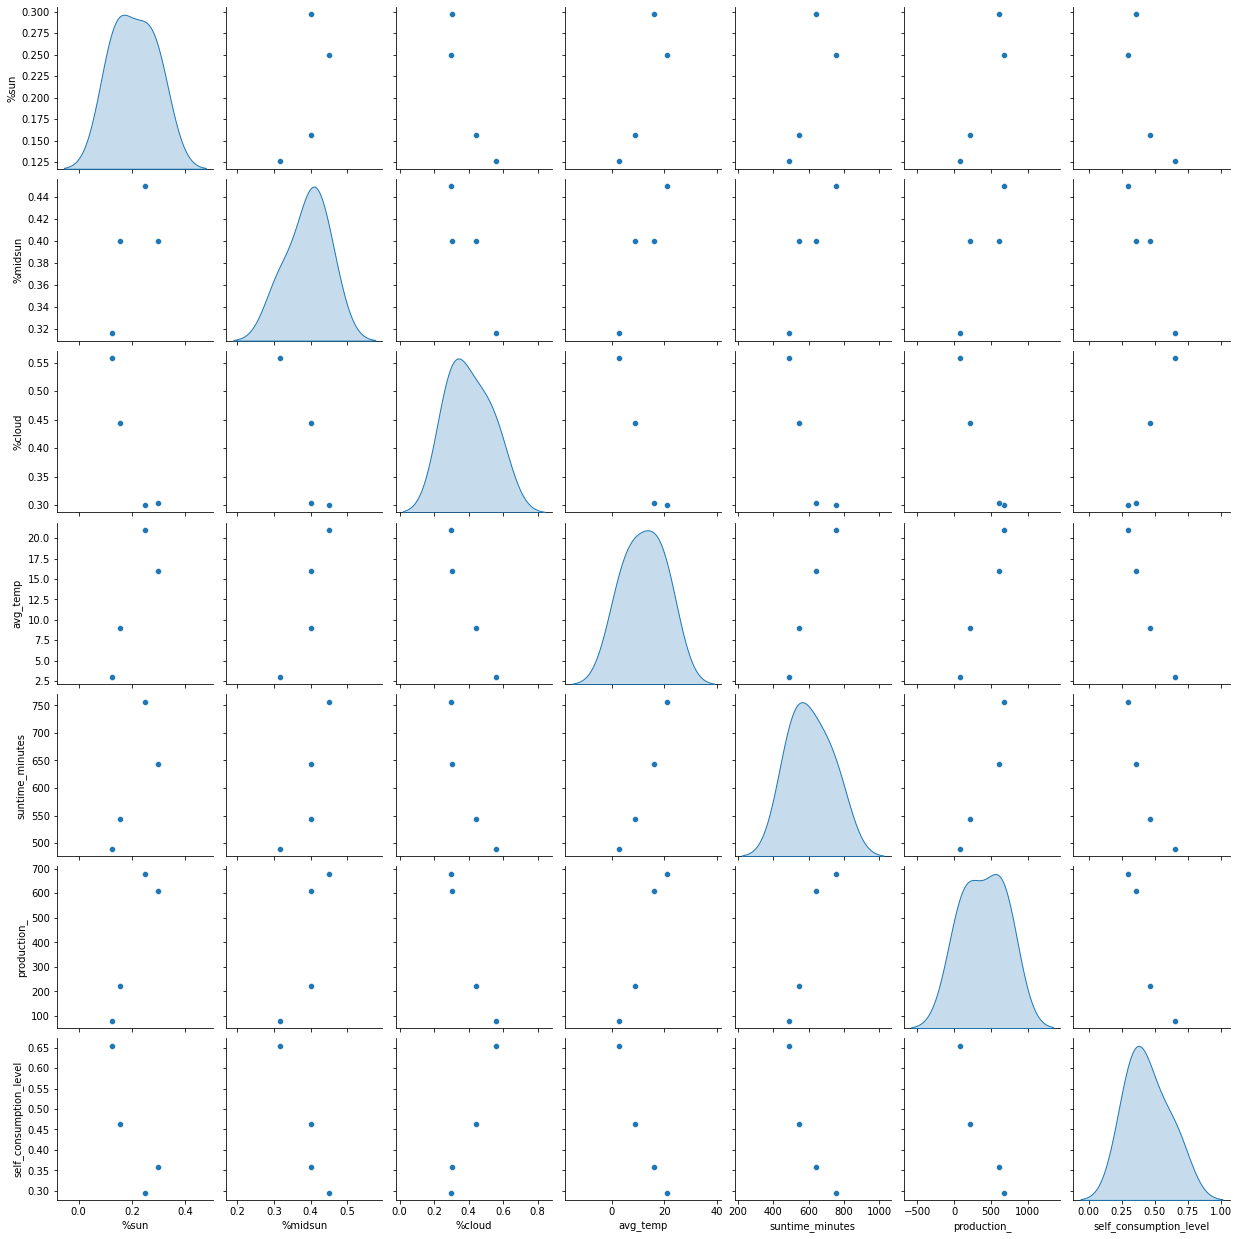

In [70]:
sns.pairplot(monthly_energy_df[MODEL_COLUMN + PROJECTION_COLUMNS],diag_kind='kde')

<AxesSubplot:>

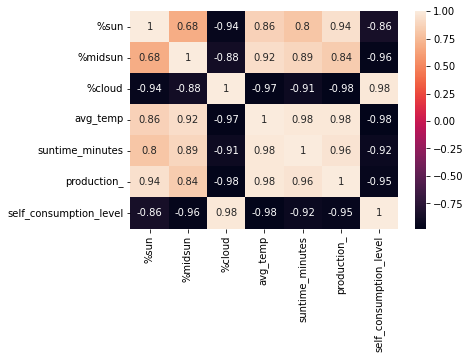

In [71]:
sns.heatmap(monthly_energy_df[MODEL_COLUMN + PROJECTION_COLUMNS].corr(),annot=True)

### Presentation graphs

In [72]:
def plot_actual_prediction(act_data, pred_data, label="production"):
    x = (monthly_energy_df['month_str'] + projection_df['month_str']).values.tolist()
    fig, ax = plt.subplots(figsize=(3, 1), dpi=200)
    ax.plot(monthly_energy_df['month_str'], act_data, label = 'real ' + label)
    ax.plot(projection_df['month_str'], pred_data, label = 'prediction ' + label)
    plt.xticks(rotation=90, fontsize="xx-small")
    plt.yticks(fontsize="xx-small")
    ax.grid()
    plt.show()

## pre-processing functions

### data standardization / normalization


In [73]:
# standardize only selected column.
# finally moved out to projection_tools.py

def standarize_data(scaler, X, fit =False, MODEL_COLUMN=MODEL_COLUMN):
    sel_left_range = 3
    keep_column, sel_column = MODEL_COLUMN[:sel_left_range], MODEL_COLUMN[sel_left_range:]
    if fit:
        scaler.fit(X[sel_column])
    temp = scaler.transform(X[sel_column])
    output_X = X[keep_column]
    output_X.loc[:, sel_column] = temp
    return output_X

## models - production

### split and standardize data

In [74]:
# select prediction column
projection_col = PROJECTION_COLUMNS[0]
X = monthly_energy_df[MODEL_COLUMN]
y = monthly_energy_df[projection_col]

In [75]:
# scaler selection
scaler = MinMaxScaler()
# standardize train test column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

X_train = standarize_data(scaler, X_train, True)
X_test =  standarize_data(scaler, X_test, False)

In [76]:
# standardize projection_df column
sel_projection_df = projection_df[MODEL_COLUMN]
standardised_projection_df = standarize_data(scaler, sel_projection_df, False)

### linear regression

scores: [ -29427.3022192   -16463.19262166 -146027.27742556]
score mean: -63972.59075547
------------------
real y_test:  [222.23] vs prediction: [310.51977861] 
mean_squared_error:  7795.08500710852
prediction:
------------------
 [ 32.78382243  18.98425249 182.57461706 414.50566544 551.46943905
 601.54563007 739.66636953 835.6404799 ]
prediction sum: 3377.1702759756768


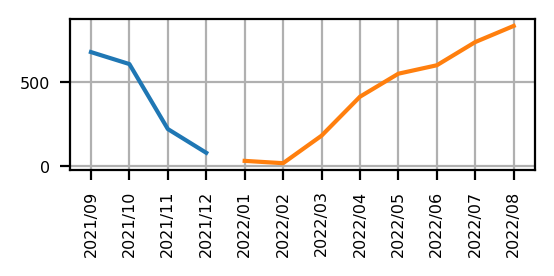

In [77]:
model = LinearRegression()

scores = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
print('scores:', scores)
print('score mean:', scores.mean())

model.fit(X_train, y_train)
y_final_test_pred = model.predict(X_test)
print("------------------\nreal y_test: ", y_test.values,"vs prediction:" , y_final_test_pred, "\nmean_squared_error: ", mean_squared_error(y_test,y_final_test_pred))
result_projection_df = model.predict(standardised_projection_df)
print('prediction:\n------------------\n', result_projection_df)
print('prediction sum:', sum(result_projection_df))

plot_actual_prediction(y, result_projection_df)

### Ridge

scores: [ -27659.94082857  -16584.93608662 -169626.39274665]
score mean: -71290.42322061303
------------------
real y_test:  [222.23] vs prediction: [304.56557098] 
mean_squared_error:  6779.146247866908
prediction:
------------------
 [ 55.72565274  72.14853598 246.68452668 482.88903144 633.33380744
 696.84581918 804.85032248 860.28954804]
prediction sum: 3852.767243977963


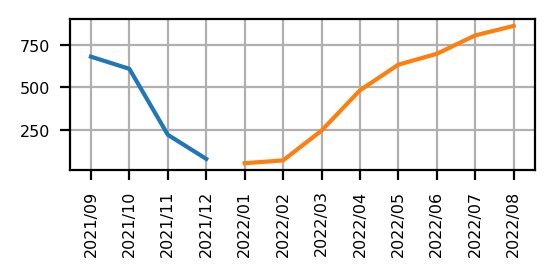

In [78]:
model = Ridge(alpha=0.005)

scores = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
print('scores:', scores)
print('score mean:', scores.mean())

model.fit(X_train, y_train)
y_final_test_pred = model.predict(X_test)
print("------------------\nreal y_test: ", y_test.values,"vs prediction:" , y_final_test_pred, "\nmean_squared_error: ", mean_squared_error(y_test,y_final_test_pred))
result_projection_df = model.predict(standardised_projection_df)
print('prediction:\n------------------\n', result_projection_df)
print('prediction sum:', sum(result_projection_df))


plot_actual_prediction(y, result_projection_df)

### polynominal regression

In [79]:
# preparing data
poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

scores: [ -88944.20295045  -40991.76025924 -211073.49207312]
score mean: -113669.81842760245
------------------
real y_test:  [222.23] vs prediction: [322.40011748] 
mean_squared_error:  10034.0524366061
prediction:
------------------
 [ 76.9856889  139.6878205  286.55237774 414.07058391 418.98676015
 388.76611042 535.8045895  731.59686654]
prediction sum: 2992.450797674388


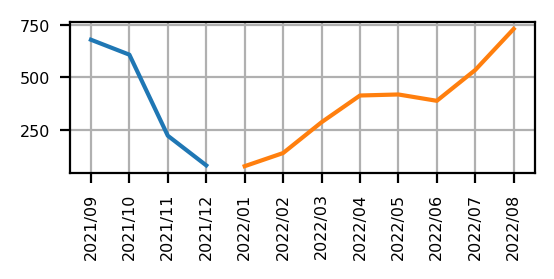

In [80]:
model = LinearRegression()

scores = cross_val_score(model, X_poly_train, y_train, cv=3, scoring='neg_mean_squared_error')
print('scores:', scores)
print('score mean:', scores.mean())

model.fit(X_poly_train, y_train)
y_final_test_pred = model.predict(X_poly_test)
print("------------------\nreal y_test: ", y_test.values,"vs prediction:" , y_final_test_pred, "\nmean_squared_error: ", mean_squared_error(y_test,y_final_test_pred))

poly_projection_df = poly.transform(standardised_projection_df)

result_projection_df = model.predict(poly_projection_df)
print('prediction:\n------------------\n', result_projection_df)
print('prediction sum:', sum(result_projection_df))

plot_actual_prediction(y, result_projection_df)

## Storage selected model - Ridge

In [81]:
model = Ridge(alpha=0.005)

scores = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
print('scores:', scores)
print('score mean:', scores.mean())

model.fit(X_train, y_train)
y_final_test_pred = model.predict(X_test)
print("------------------\nreal y_test: ", y_test.values,"vs prediction:" , y_final_test_pred, "\nmean_squared_error: ", mean_squared_error(y_test,y_final_test_pred))
result_projection_df = model.predict(standardised_projection_df)
print('prediction:\n------------------\n', result_projection_df)
print('prediction sum:', sum(result_projection_df))

scores: [ -27659.94082857  -16584.93608662 -169626.39274665]
score mean: -71290.42322061303
------------------
real y_test:  [222.23] vs prediction: [304.56557098] 
mean_squared_error:  6779.146247866908
prediction:
------------------
 [ 55.72565274  72.14853598 246.68452668 482.88903144 633.33380744
 696.84581918 804.85032248 860.28954804]
prediction sum: 3852.767243977963


In [82]:
model_name = MODEL_NAME[0]
with open(STORAGE_DIR + model_name, 'wb') as file:
    pickle.dump(model, file)
    pickle.dump(scaler, file)
    pickle.dump(MODEL_COLUMN, file)
    pickle.dump(standarize_data, file)
    
print('model {} saved'.format(model_name))

model energy_production_model.pkl saved


## Models - self consumption level

### adding production to models

In [83]:
projection_df['production_'] = result_projection_df
# merge weather data with energy dataframe
X = monthly_energy_df[MODEL_COLUMN + ['production_']]
y = master_monthly_energy_df['self_consumption_'] / master_monthly_energy_df['production_']
MODEL_COLUMN.append(PROJECTION_COLUMNS[0])

### split and standardize data

In [84]:
# standardize train test column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

X_train = standarize_data(scaler, X_train, True)
X_test =  standarize_data(scaler, X_test, False)

In [85]:
# select prediction column
projection_col = PROJECTION_COLUMNS[1]

In [86]:
# standardize projection_df column
sel_projection_df = projection_df[MODEL_COLUMN]
standardised_projection_df = standarize_data(scaler, sel_projection_df, False)

### linear regression

scores: [-0.00100391 -0.00108748 -0.0300328 ]
score mean: -0.010708062339195188
------------------\nreal y_test:  [0.46268731] vs prediction: [0.56453437] 
mean_squared_error:  0.010372824039724522
prediction:
------------------
 [0.6549531  0.612763   0.49716559 0.35239593 0.25207296 0.22155222
 0.17049572 0.17987302]
prediction avg: 0.3676589432160091


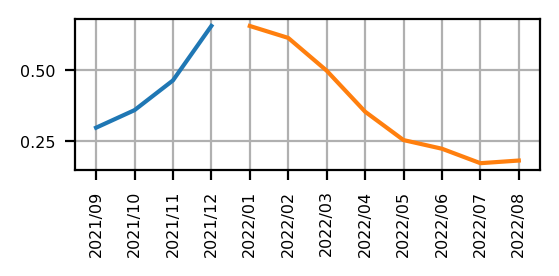

In [87]:
model = LinearRegression()

scores = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
print('scores:', scores)
print('score mean:', scores.mean())

model.fit(X_train, y_train)
y_final_test_pred = model.predict(X_test)
print("------------------\\nreal y_test: ", y_test.values,"vs prediction:" , y_final_test_pred, "\nmean_squared_error: ", mean_squared_error(y_test,y_final_test_pred))
result_projection_df = model.predict(standardised_projection_df)
print('prediction:\n------------------\n', result_projection_df)
print('prediction avg:', result_projection_df.mean())

plot_actual_prediction(y, result_projection_df)

### Ridge

scores: [-0.00091784 -0.00110552 -0.0319635 ]
score mean: -0.011328952430006324
------------------\nreal y_test:  [0.46268731] vs prediction: [0.55572126] 
mean_squared_error:  0.008655316505793953
prediction:
------------------
 [0.66383529 0.63965318 0.5305542  0.38793181 0.29196289 0.24775651
 0.19783077 0.18415777]
prediction avg: 0.3929603033149035


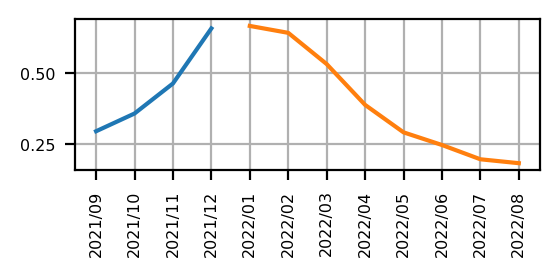

In [88]:
model = Ridge(alpha=0.005)

scores = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
print('scores:', scores)
print('score mean:', scores.mean())

model.fit(X_train, y_train)
y_final_test_pred = model.predict(X_test)
print("------------------\\nreal y_test: ", y_test.values,"vs prediction:" , y_final_test_pred, "\nmean_squared_error: ", mean_squared_error(y_test,y_final_test_pred))
result_projection_df = model.predict(standardised_projection_df)
print('prediction:\n------------------\n', result_projection_df)
print('prediction avg:', (result_projection_df.mean()))


plot_actual_prediction(y, result_projection_df)

### polynominal regression

In [89]:
# preparing data
poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

scores: [-0.00780415 -0.00580276 -0.05077662]
score mean: -0.0214611742602541
------------------\nreal y_test:  [0.46268731] vs prediction: [0.57395496] 
mean_squared_error:  0.012380491817920208
prediction:
------------------
 [0.66129729 0.64746123 0.57315885 0.45185278 0.36701391 0.33021245
 0.23405711 0.16291563]
prediction avg: 0.42849615663221624


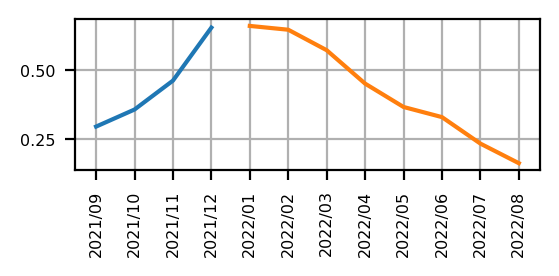

In [90]:
model = LinearRegression()

scores = cross_val_score(model, X_poly_train, y_train, cv=3, scoring='neg_mean_squared_error')
print('scores:', scores)
print('score mean:', scores.mean())

model.fit(X_poly_train, y_train)
y_final_test_pred = model.predict(X_poly_test)
print("------------------\\nreal y_test: ", y_test.values,"vs prediction:" , y_final_test_pred, "\nmean_squared_error: ", mean_squared_error(y_test,y_final_test_pred))

poly_projection_df = poly.transform(standardised_projection_df)

result_projection_df = model.predict(poly_projection_df)
print('prediction:\n------------------\n', result_projection_df)
print('prediction avg:', result_projection_df.mean())

plot_actual_prediction(y, result_projection_df)

## Storage selected model - Ridge

In [91]:
model = Ridge(alpha=0.005)

scores = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
print('scores:', scores)
print('score mean:', scores.mean())

model.fit(X_train, y_train)
y_final_test_pred = model.predict(X_test)
print("------\nreal y_test: ", y_test.values,"vs prediction:" , y_final_test_pred, "\nmean_squared_error: ", mean_squared_error(y_test,y_final_test_pred))
result_projection_df = model.predict(standardised_projection_df)
print('prediction:\n------------------\n', result_projection_df)
print('prediction sum:', sum(result_projection_df))

scores: [-0.00091784 -0.00110552 -0.0319635 ]
score mean: -0.011328952430006324
------
real y_test:  [0.46268731] vs prediction: [0.55572126] 
mean_squared_error:  0.008655316505793953
prediction:
------------------
 [0.66383529 0.63965318 0.5305542  0.38793181 0.29196289 0.24775651
 0.19783077 0.18415777]
prediction sum: 3.143682426519228


In [92]:
model_name = MODEL_NAME[1]
with open(STORAGE_DIR + model_name, 'wb') as file:
    pickle.dump(model, file)
    pickle.dump(scaler, file)
    pickle.dump(MODEL_COLUMN, file)
    pickle.dump(standarize_data, file)
    
print('model {} saved'.format(model_name))

model energy_self_consumption_model.pkl saved


In [93]:
projection_df

,month,month_str,%sun,%midsun,%cloud,avg_temp,suntime_minutes,production_
0,1,2022/01,0.116129,0.335484,0.548387,2,518.451613,55.725653
1,2,2022/02,0.113475,0.354610,0.531915,3,608.068966,72.148536
2,3,2022/03,0.141935,0.435484,0.422581,8,714.806452,246.684527
3,4,2022/04,0.190000,0.496667,0.313333,15,828.066667,482.889031
4,5,2022/05,0.212903,0.525806,0.261290,20,926.451613,633.333807
5,6,2022/06,0.160000,0.600000,0.240000,23,978.066667,696.845819
6,7,2022/07,0.248387,0.548387,0.203226,25,952.451613,804.850322
7,8,2022/08,0.274194,0.525806,0.200000,26,865.612903,860.289548


# Final graph presentation

In [96]:
projection_df['self_consumption_'] = result_projection_df * projection_df['production_']
print(savings_df_report(monthly_energy_df, "historical data summary", kWh_cost = energy_df.kWh_cost, curr = energy_df.currency))
print(savings_df_report(projection_df, "projection data summary", kWh_cost = energy_df.kWh_cost, curr = energy_df.currency))

historical data summary
        ---------------------------------------------
        production              :  1,591.80
        self consumption        :    574.71
        self consumption level  :    36.10%
        savings                 :  1,388.38 kWh
                                :    902.45 PLN
                            
projection data summary
        ---------------------------------------------
        production              :  3,852.77
        self consumption        :  1,076.56
        self consumption level  :    27.94%
        savings                 :  3,297.53 kWh
                                :  2,143.39 PLN
                            


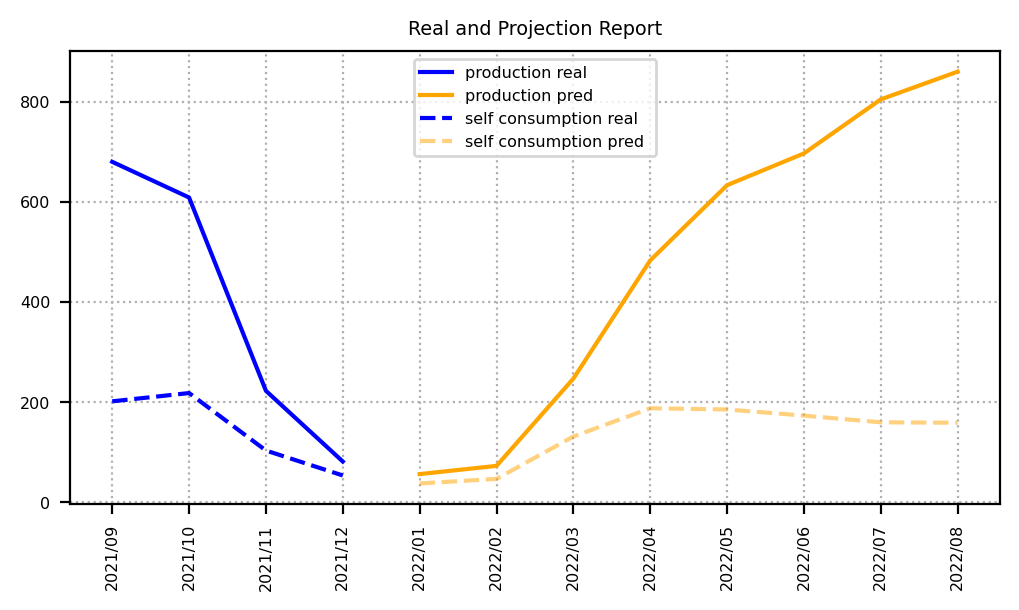

In [97]:
plt = projection_in_graph(monthly_energy_df, projection_df)
plt.show()